In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import HBox, Label, VBox
from IPython.display import display

### Function: DropTime
Calculates preform drop time for a given temperature  
  
Input: T (degress celcius) - furnace temperature, range is 1600C to 2200C  
Return: DT (minutes)  - drop time  
Return: err_DT (boolean) - true if drop time is greater than 20 minutes, else false

In [3]:
# Define the function DropTime
def DropTime(T):
    err_DT=False
    DT = 3*np.exp(6.2000279*10**4*(1/T-1/2175))
    if DT > 20:
        err_DT=True
    return DT, err_DT

#### Code to test DropTime

Drop time too long = True


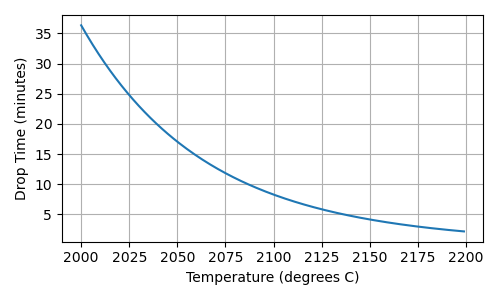

In [4]:
Tmin=2000
Tmax=2200
T=[]
Time=[]
for temp in range(Tmin,Tmax):
    T.append(temp)
    Time.append(DropTime(temp)[0])
fig, ax = plt.subplots(figsize=(5, 3),dpi=100)
fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'right'
fig.canvas.toolbar_visible = False
# ax.set_title('Title')
ax.set_xlabel('Temperature (degrees C)')
ax.set_ylabel('Drop Time (minutes)')
ax.grid(True)
line, = ax.plot(T,Time)

# Test with T=2025C
DT,err_DT = DropTime(2025)
print('Drop time too long =', str(err_DT))

### Function FiberDiameter
Calulates fiber diameter from preform diameter, feed speed, and pull speed  
  
Input: Dpf (centimeter) - preform diameter  
Input: vpf (micron/sec) - preform feed speed  
Input: Psp (meter/sec) - fiber pull speed  
  
Return: Dfib (micron) - fiber diameter  
Return: err_Dfib1 (boolean) - true if fiber diameter is less than or equal to 80 micron, else false  
Return: err_Dfib2 (boolean) -  true if fiber diameter is greater than or equal to 200 micron, else false

In [5]:
def FiberDiameter(Dpf,vpf,Psp):
    err_Dfib1=False
    err_Dfib2=False
    Dfib = Dpf*(vpf*1e-6/Psp)**0.5*1e4
    if Dfib <= 80:
        err_Dfib1=True
    elif Dfib >= 200:
        err_Dfib2 = True
    return Dfib, err_Dfib1, err_Dfib2

#### Code to Test FiberDiameter

Fiber diameter too small = False
Fiber diameter too large = True


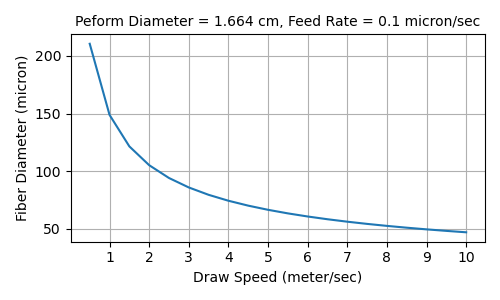

In [6]:
Dpf = 1.664 # Diamter of preform is 1.6641968 cm
vpf=80 # Feed speed in micron per sec
Pspmin=0.5
Pspmax=10
Psparr=[]
Dfibarr=[]
for drawspeed in range(int(Pspmin*2),int(Pspmax*2)+1):
    Psparr.append(drawspeed/2)
    Dfibarr.append(FiberDiameter(Dpf,vpf,drawspeed/2.0)[0])
fig, ax = plt.subplots(figsize=(5, 3),dpi=100)
fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'right'
fig.canvas.toolbar_visible = False
ax.set_title('Peform Diameter = 1.664 cm, Feed Rate = 0.1 micron/sec', fontsize = 10)
ax.set_xlabel('Draw Speed (meter/sec)')
ax.set_ylabel('Fiber Diameter (micron)')
ax.grid(True)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11])
# ax.grid(which='major', linewidth='0.5', color='black')
line, = ax.plot(Psparr,Dfibarr)

# Test with Dpf=1.664 cm, vpf=1e-4 cm/min, and vfib = 8 m/min
Dfib,err_Dfib1,err_Dfib2=FiberDiameter(Dpf,vpf,0.01)
print('Fiber diameter too small =', str(err_Dfib1))
print('Fiber diameter too large =', str(err_Dfib2))

### Function FiberTension
Input: Temp - Furnace temperature  
Input: Dfib (centimeter) - Fiber diameter  
Input: Dpf (centimeter) - Preform diameter  
Input: Psp (meter/second) - Draw (pull) speed  
  
Return: Tension (gram) - use as input for the gauge_value function  
Return: err_Tension_low (boolean) - True if tension is too low, else False  
Return: err_Tension_high (boolean) - True if tension is too high, else False

In [16]:
def FiberTension(Temp, Dfib, Dpf, Psp):
    err_Tension_low=False
    err_Tension_high=False
    # Calculate the viscosity factor
    eta=np.exp(515400/8.31446/(Temp+273.15))/np.exp(515400/8.31446/(1927+273.15))
    # Calculation of tension (np.pi = 3.14159)
    beta = np.log(118e-4/1.664)/np.log(Dfib*1e-4/1.664) # Adds pull speed dependence to tension
    Tension = 6*eta*(Dfib/118)**2*(Psp/7)*beta
    if Tension > 6*(Dfib/118)**2:
        err_Tension_low=True
    elif Tension < 0.1*(Dfib/118)**2:
        err_Tension_high=True       
    return Tension, err_Tension_low, err_Tension_high  

### Function gauge_value
This function takes values of tension and fiber diameter and computes corresponding values in the range of -1 to 1 to use as inputs for a gauge display 
  
Input: Tmin (gram) - set to 0.1 (values of Tension below this value will display in the lower quarter of the gauge range)    
Input: Tmax (gram) - set to 6.0 (values of Tensions above this value will display in the upper quarter of the gauge range)  
Input: Tension (gram) - value that is returned from the FiberTension function  
Input: dfib (cm) - fiber diameter  
  
Return: gval (no units) - use as input for a gauge display

In [17]:
def gauge_value(Tmin,Twarn_low,Twarn_high,Tmax,Tension,dfib):
    Tens=Tension*(118e-4/Dfib)**2
    if Tension > Tmax:
        g_val=0.6*np.tanh(Tension/Tmax)/np.tanh(1)
    elif Tension <= Tmax and Tension > Twarn_high:
        g_val=0.2+(Tension-Twarn_high)/(Tmax-Twarn_high)*0.4
    elif Tension <= Twarn_high and Tension >= Twarn_low:
        g_val=-0.2+(Tension-Twarn_low)/(Twarn_high-Twarn_low)*0.4
    elif Tension < Twarn_low and Tension >= Tmin:
        g_val=-0.6 + (Tension-Tmin)/(Twarn_low-Tmin)*0.4
    else:
        g_val=-0.6*np.tanh(Tmin/Tension)/np.tanh(1)
    return g_val

#### A gauge display to test the function gauge_value

In [18]:
Dpf = 1.664 # Diamter of preform is 1.6641968 cm
vpf=1*10**-4 # Feed speed in m per sec
Tmin=0.1 # minimum tension in grams
Twarn_low=0.5 # low tension warning in grams
Twarn_high=4 # High tension warning in grams
Tmax=6.0 # maximum tension in grams

# style = {'description_width': 'initial'}
style={'bar_color': 'green','description_width': 'initial'}

t_dis = widgets.FloatProgress(
    value=0,
    min=-1.0,
    max=1.0,
    step=0.01,
    readout_format='.3f',
    description='',
    bar_style='info',
    style=style,
    orientation='horizontal')

Psp_adj = widgets.FloatSlider(
    value=0.1,
    min=0.1,
    max=15,
    step=0.01,
    readout_format='.3f',
    description='',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    layout=widgets.Layout(width='25%'),
    readout=True)

Temp_adj = widgets.FloatSlider(
    value=1925,
    min=1700,
    max=2400,
    step=25,
    readout_format='.3f',
    description='',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    layout=widgets.Layout(width='25%'),
    readout=True)

vpf_adj = widgets.FloatSlider(
    value=6.0,
    min=1.0,
    max=800,
    step=1.0,
    readout_format='.3f',
    description='',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    layout=widgets.Layout(width='25%'),
    readout=True)

t_val_output = widgets.Output(layout={'height': '30px', 'width': '200px', 'border': '1px solid black'})
Dfib_val_output = widgets.Output(layout={'height': '30px', 'width': '230px', 'border': '1px solid black'})

with t_val_output:
    t_val_output.clear_output()
    print('Tension =', '{:.2f}'.format(t_val), ' gram')
with Dfib_val_output:
    Dfib_val_output.clear_output()
    print('Fiber Diameter =', '{:.0f}'.format(Dfib*10**4), ' micron')

def update(*args):
    Temp=Temp_adj.value
    Pspeed=Psp_adj.value
    vfeed=vpf_adj.value
    Dfib,err_Dfib1,err_Dfib2=FiberDiameter(Dpf,vfeed,Pspeed)
    t_val=FiberTension(Temp, Dfib, Dpf, Pspeed)[0]
    t_dis.value=gauge_value(Tmin,Twarn_low,Twarn_high,Tmax,t_val,Dfib)
    t_dis.style=style={'bar_color': 'red'}
    if t_val > Twarn_high and t_val <= Tmax:
        t_dis.style=style={'bar_color': 'yellow'}
    elif t_val >= Twarn_low and t_val <= Twarn_high:
        t_dis.style=style={'bar_color': 'green'}
    elif t_val < Twarn_low and t_val >= Tmin:
        t_dis.style=style={'bar_color': 'yellow'}
    else:
        t_dis.style=style={'bar_color': 'red'}
    with t_val_output:
        t_val_output.clear_output()
        print('Tension =', '{:.2f}'.format(t_val), ' gram')
    with Dfib_val_output:
        Dfib_val_output.clear_output()
        print('Fiber Diameter =', '{:.0f}'.format(Dfib), ' micron')
    if err_Dfib1 or err_Dfib2:
        Dfib_val_output.layout={'height': '30px', 'width': '230px', 'border': '4px solid red'}
    else:
        Dfib_val_output.layout={'height': '30px', 'width': '230px', 'border': '1px solid black'}

update()

Dfib_val_output.layout={'height': '30px', 'width': '230px', 'border': '1px solid black'}
Psp_adj.observe(update,names='value')
Temp_adj.observe(update,names='value')
vpf_adj.observe(update,names='value')

VBox([Label('Preform Diameter = 1.644 cm'),
    HBox([Label('Furance Temp (C)'),Temp_adj]),
    HBox([Label('Preform Feed Speed (micron/sec)'),vpf_adj]),
    HBox([Label('Pull Speed (m/s)'),Psp_adj]),
      HBox([Label('Tension_Gauge'),t_dis]),
     t_val_output,Dfib_val_output])

#### Stage 3 - Set-up with low pull speed (< 0.7 m/s)  (125 micron diameter fiber)
Error/Warning States:  
Tension too high and in the red zone - fiber break, operator must start over  
Tension too high and in the yellow zone or too low - warnings issued but OK to proceed  
Fiber diameter less than 80 micron - fiber break, operator must start over
Fiber diameter greater than 200 micron - warning issued but OK to proceed
  
Initial Settings:  
Furnace Temp = 1925  
Preform Feed Speed = 20.0 micron/sec  
Pull Speed = 1 meter/second  
  
Solution:  
Preform Feed Speed 30 micron/sec  
Pull Speed = 0.53 meter/sec  
(Tension in green range @ 0.52 gram)

#### Tutorial 1 - Set-up with high pull speed (> 3 m/s)  (125 micron diameter fiber)
Tension and diameter warnings issued but operator will not be required to start over  
  
Initial Settings:  
Furnace Temp = 1925 C  
Preform Feed Speed = 30.0 micron/sec  
Pull Speed = 0.53 meter/second  
  
Solution:  (Fastest pull speed I could get with tension in green zone)
Preform Feed Speed 210 micron/sec  
Pull Speed = 3.7 meter/sec  
(Tension in greed range @ 3.85 gram)  
  
#### Stage 5 - Faster pull speed with higher furnace temp (> 10 m/s)  (125 micron diameter fiber)
Error/Warning States:  
Tension too high and in the red zone - fiber break, start over  
Tension too high and in the yellow zone or too low - warnings issued but OK to proceed  
Fiber diameter less than 80 or greater than 200 micron, fiber break, start over  
  
Initial Settings:  
Furnace Temp = 1925 C  
Preform Feed Speed = 220 micron/sec  
Pull Speed = 3.5 meter/second  
  
Solution:  (Fastest pull speed I could get with tension in green zone)
Furnace Temp = 2025 C
Preform Feed Speed 700 micron/sec  
Pull Speed = 12.4 meter/sec  
(Tension in greed range @ 3.57 gram) 